In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging
import json
import random

import numpy as np
import json
from tqdm.notebook import tqdm


# Set-up

## Load data

In [34]:
# Load imagenet


# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Get class names
imagenet_class_nums = np.arange(0, 1000, 1)
imagenet_class_names = ["{}".format(get_class_name(i)) for i in imagenet_class_nums]

# Set the seed. You don't need indices if data is loaded in same order every time.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet dataset
batch_size = 1
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)
data_loader = DataLoader(imagenet_data, batch_size=batch_size, shuffle=True) # Need to reinstantiate the dataset each time for fixed order 



## Load model

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Text(0.5, 1.0, 'Predicted: Welsh_springer_spaniel. True: Lhasa')

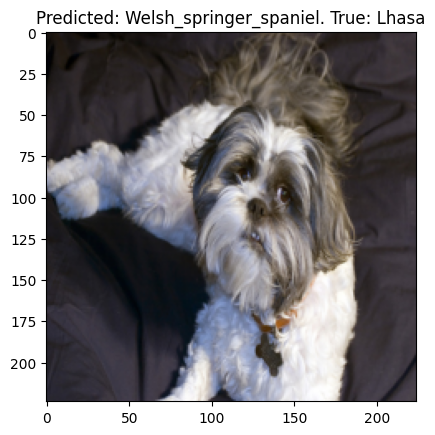

In [35]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M")
processor = CLIPProcessor.from_pretrained("wkcn/TinyCLIP-ViT-8M-16-Text-3M-YFCC15M", do_rescale=False) # Make sure the do_rescale is false for pytorch datasets

images, labels = next(iter(data_loader))

idx = 0

inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
# predicted_class = imagenet_class_names[probs.argmax(dim=1)]
predicted_indices = probs.argmax(dim=1)

plt.imshow(images[idx].permute(1, 2, 0))
plt.title(f"Predicted: {get_class_name(predicted_indices[idx].item())}. True: {get_class_name(labels[idx].item())}")

# Visualize maximally activating neurons

In [5]:
# from tqdm.notebook import tqdm

# # Function to register the hook
# def register_hook(module, activations_list):
#     def hook(module, input, output):
#         activations_list.append(output.detach())
#     return module.register_forward_hook(hook)

# # Get activations per batch.
# def process_images(model, processor, images, labels, activations_list, batch_idx):
#     detailed_activations = []

#     activations_list.clear()

#     # Process the entire batch of images and labels
#     inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
#     outputs = model(**inputs)

#     class_names = [get_class_name(label.item()) for label in labels]
#     logits_per_image = outputs.logits_per_image
#     probs = logits_per_image.softmax(dim=1)
#     predicted_class_indices = probs.argmax(dim=1)
#     predicted_class_names = [imagenet_class_names[idx] for idx in predicted_class_indices]

#     # Iterate through each datapoint in the batch
#     for image_idx, batch_activations in enumerate(activations_list[0]):
#         # Iterate through patches per batch
#         for patch_idx, patch_activations in enumerate(batch_activations):
#             # Iterate through neurons per patch
#             for neuron_idx, activation_value in enumerate(patch_activations):
#                 detailed_activations.append({
#                     'batch_idx': batch_idx,
#                     'image_idx': image_idx,
#                     'class_name': class_names[image_idx],
#                     'predicted': predicted_class_names[image_idx],
#                     'patch_idx': patch_idx,
#                     'neuron_idx': neuron_idx,
#                     'activation_value': activation_value.item()
#                 })

#     return detailed_activations

# global activations_list
# activations_list = []

# layer_num=8
# module = model.vision_model.encoder.layers[layer_num].mlp.fc1 # Layer number here
# hook_handle = register_hook(module, activations_list)

# # Process images

# MAX_BATCH_COUNT = 1 # Number of batches (10 x 64  = 640 images)
# count = 0

# total_layer_activations = []
# for idx, (images, labels) in tqdm(enumerate(data_loader), total=MAX_BATCH_COUNT):
#     detailed_activations = process_images(model, processor, images, labels, activations_list, batch_idx=0)
#     total_layer_activations.extend(detailed_activations)

#     count += 1
#     if count > MAX_BATCH_COUNT:
#         break


# # Remove the hook when done
# hook_handle.remove()


In [6]:
# import pickle


# save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
# file_name = f'mlp_fc1_{8}.npz'

# # Make directory if doesn't exist
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# np.savez_compressed(os.path.join(save_path, file_name), activations=total_layer_activations)

# # Save
# # with open(os.path.join(save_path, file_name), 'wb') as file:
# #     pickle.dump(total_layer_activations, file)

# # # Save activations
# # with open(os.path.join(save_path, file_name), 'w') as file:
# #     json.dump(total_layer_activations, file)

In [7]:

# # Check if the file exists
# if os.path.exists(file_path):
#     # Load the JSON file
#     with open(file_path, 'r') as file:
#         loaded_activations = json.load(file)
#     print("Activations loaded successfully.")
# else:
#     print("File does not exist.")


In [36]:
from tqdm.notebook import tqdm

# Individual batch version. Having batch size = 1 is empirically faster than getting a batch large and then iterating through it. Not sure why, may be RAM reasons.

# Function to register the hook
def register_hook(module, activations_list):
    def hook(module, input, output):
        activations_list.append(output.detach())
    return module.register_forward_hook(hook)

def process_images(model, processor, total_images, total_labels, batch_idx):
    detailed_activations = []

    # Takes in batch size = 1 at a time.
    for i, (images, labels) in enumerate(zip(total_images, total_labels)):
        activations_list.clear()

        inputs = processor(text=imagenet_class_names, images=images, return_tensors="pt", padding=True)
        outputs = model(**inputs)

        class_name = get_class_name(labels.item())
        
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
        predicted_class_name = imagenet_class_names[probs.argmax(dim=1)]

        # Assuming batch size of 1 for simplicity.
        # Enumerate through patches and neurons to get each value
        for patch_idx, patch_activations in enumerate(activations_list[0][0]): # Get first batch
            for neuron_idx, activation_value in enumerate(patch_activations):
                detailed_activations.append({
                    'batch_idx': batch_idx,
                    # 'image_idx': i,
                    'class_name': class_name,
                    'predicted': predicted_class_name,
                    'patch_idx': patch_idx,
                    'neuron_idx': neuron_idx,
                    'activation_value': activation_value.item()
                })


    return detailed_activations

# Example usage
activations_list = []

module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here
hook_handle = register_hook(module, activations_list)

# total_images, total_labels = next(iter(data_loader))

master_layer_activations = []
MAX=250

count = 0
for batch_idx, (total_images, total_labels) in tqdm(enumerate(data_loader), total=MAX):
        detailed_activations = process_images(model, processor, total_images, total_labels, batch_idx=batch_idx)
        master_layer_activations.append(detailed_activations)
        count += 1
        if count >= MAX:
            break

# Remove the hook when done
hook_handle.remove()


  0%|          | 0/250 [00:00<?, ?it/s]

In [37]:
import pandas as pd 

flattened_activations = [item for sublist in master_layer_activations for item in sublist]
df_activations = pd.DataFrame(flattened_activations)

save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
layer_num = 8
file_name = f'mlp_fc1_{layer_num}.npz'

parquet_file_path = os.path.join(save_path, file_name)
df_activations.to_parquet(parquet_file_path, index=False)



In [46]:
for layer_num in range(9):
    data_loader = DataLoader(imagenet_data, batch_size=batch_size, shuffle=True) # Need to reinstantiate the dataset each time for fixed order 

    save_path = f'/network/scratch/s/sonia.joseph/clip_mechinterp/tinyclip/mini_dataset/'
    file_name = f'mlp_fc1_{layer_num}.npz'

    # Make directory if doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Example usage
    activations_list = []

    module = model.vision_model.encoder.layers[layer_num].mlp.fc1 # Layer number here
    hook_handle = register_hook(module, activations_list)


    master_layer_activations = []
    MAX=500 
    count = 0
    for batch_idx, (total_images, total_labels) in tqdm(enumerate(data_loader), total=MAX):
            detailed_activations = process_images(model, processor, total_images, total_labels, batch_idx=batch_idx)
            master_layer_activations.append(detailed_activations)
            count += 1
            if count >= MAX:
                break

    # Remove the hook when done
    hook_handle.remove()

    parquet_file_path = os.path.join(save_path, file_name)
    df_activations.to_parquet(parquet_file_path, index=False)

    print(f"Saved {layer_num} as parquet")

  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
filtered_df.sort_values(by=['activation_value'], ascending=False, inplace=True)
filtered_df.head(1000).style.background_gradient("coolwarm")

## View maximally/minimally activating neurons (per patch)

In [13]:
import pandas as pd

# Assume detailed_activations is filled with your data

# Convert to DataFrame
# activations_df = pd.DataFrame(detailed_activations)

# Sort by max_activation_value in descending order
activations_df_sorted = df.sort_values(by='activation_value', ascending=False)

activations_df_sorted.head(100).style.background_gradient("coolwarm")


### Histogram plot of activations per neuron

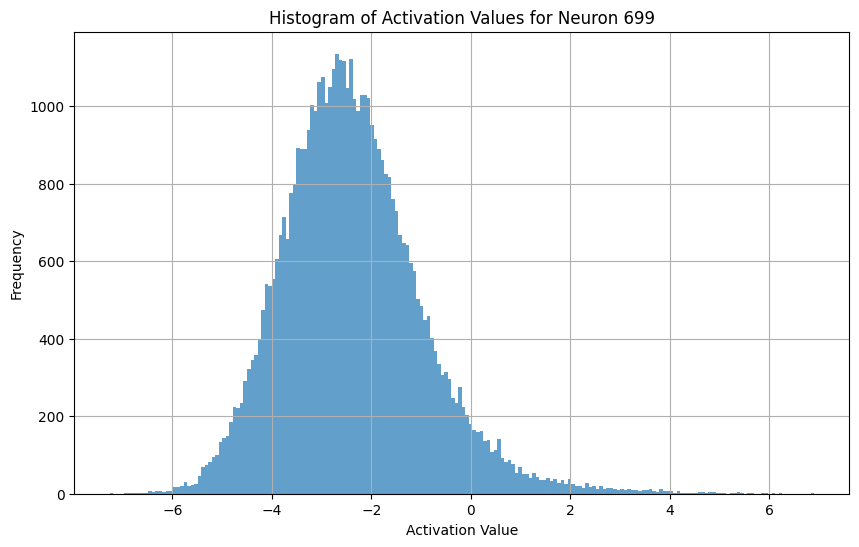

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


# Should this be in log scale?

neuron_of_interest = 699

# Filter the DataFrame to only include the neuron of interest
filtered_df = df[df['neuron_idx'] == neuron_of_interest]

# Create a histogram of the activation values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['activation_value'], bins=200, alpha=0.7)
plt.title(f'Histogram of Activation Values for Neuron {neuron_of_interest}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Do this in log scale? 


### Visualize heatmap for specific image + neuron

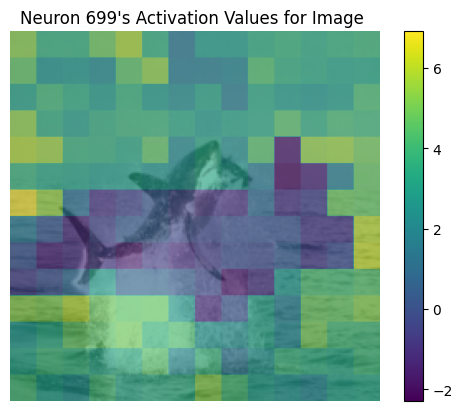

In [28]:
import pandas as pd

# Example values, replace with the ones you're interested in
specific_neuron_idx = 699 # Replace X with the neuron index you're interested in

specific_image_idx = 139 # Change this to automatically return top 10 images, display all together

# Filter the DataFrame to only include rows for the specific image and neuron
filtered_df = df[(df['batch_idx'] == specific_image_idx) & 
                             (df['neuron_idx'] == specific_neuron_idx)]


activation_values = filtered_df['activation_value']

# Step 2: Convert to a NumPy array
activation_values_array = activation_values.to_numpy()[1:]

def plot_image_patch_heatmap(activation_values_array, image, specific_neuron_idx, image_size=224, pixel_num=14):

    activation_values_array = activation_values_array.reshape(pixel_num, pixel_num)

    # Create a heatmap overlay
    heatmap = np.zeros((image_size, image_size))
    patch_size = image_size // pixel_num

    for i in range(pixel_num):
        for j in range(pixel_num):
            heatmap[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = activation_values_array[i, j]

    # Plotting the image with the heatmap overlay
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1,2,0))
    ax.imshow(heatmap, cmap='viridis', alpha=0.6)  # Overlaying the heatmap

    # Removing axes
    ax.axis('off')

    min_activation = activation_values_array.min()
    max_activation = activation_values_array.max()

    # Adding colorbar for the heatmap
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_activation, vmax=max_activation)), ax=ax, orientation='vertical')

    plt.title("Neuron {}'s Activation Values for Image {}".format(specific_neuron_idx, ""))
    plt.show()


plot_image_patch_heatmap(activation_values_array, imagenet_data[specific_image_idx][0], specific_neuron_idx, image_size=224)


### Return top 10 patches per neuron and display corresponding images

AttributeError: 'Tensor' object has no attribute 'width'

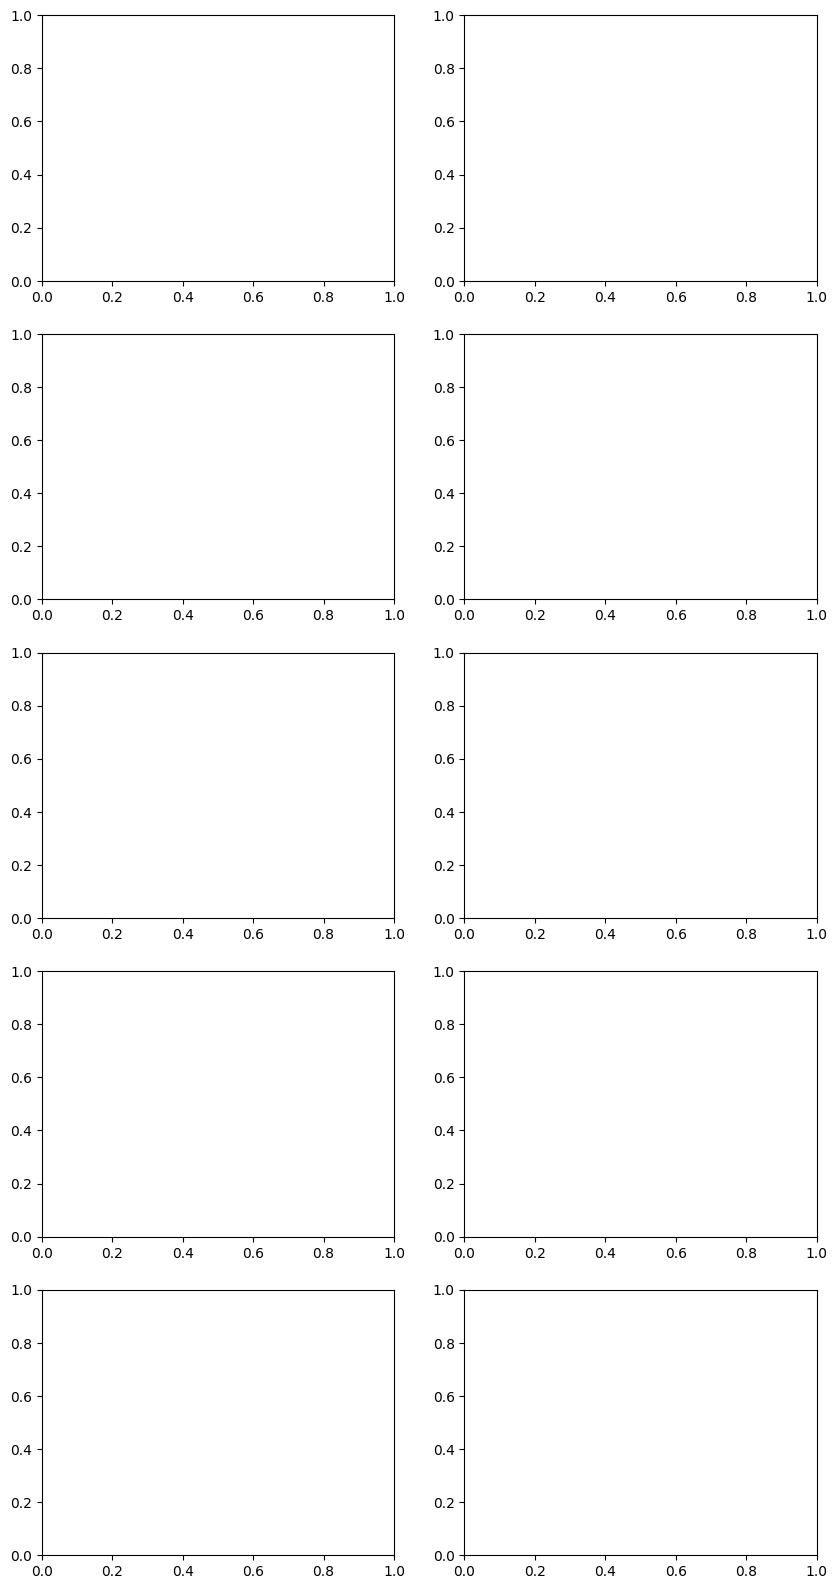

In [ ]:
def get_top_patches(activations_df, neuron_idx, top_n=10):
    # Filter the DataFrame for the specified neuron
    filtered_df = activations_df[activations_df['neuron_idx'] == neuron_idx]

    # Sort by 'activation_value' in descending order and get the top N patches
    top_patches_df = filtered_df.sort_values(by='activation_value', ascending=False).head(top_n)

    return top_patches_df

# Example usage: Get top 10 patches for neuron index 5
neuron_index = 5
top_patches_df = get_top_patches(activations_df, neuron_index)
import matplotlib.pyplot as plt
from PIL import Image

def plot_top_patches(top_patches_df, image_mapping):
    fig, axs = plt.subplots(5, 2, figsize=(10, 20)) # 5x2 grid
    axs = axs.flatten()

    for idx, row in enumerate(top_patches_df.itertuples()):
        image_idx = row.image_idx
        patch_idx = row.patch_idx

        # Load the image (you need to define how to get the path from image_idx)
        image = image_mapping[image_idx] # Replace with your method to get image path

        # Assuming a 4x4 grid, calculate patch coordinates (excluding CLS token)
        patch_size = image.width // 4
        patch_x = (patch_idx % 4) * patch_size
        patch_y = (patch_idx // 4) * patch_size
        patch = image.crop((patch_x, patch_y, patch_x + patch_size, patch_y + patch_size))

        axs[idx].imshow(patch)
        axs[idx].axis('off')
        axs[idx].set_title(f'Image: {image_idx}, Patch: {patch_idx}, Neuron: {neuron_index}')

    plt.tight_layout()
    plt.show()

# Example usage
plot_top_patches(top_patches_df, total_images)



In [ ]:
# # Generate text descriptions for every patch

# # save the original activations

# def register_hook(module, activations_list):
#     def hook(module, input, output):
#         activations_list.append(output.detach())
#     return module.register_forward_hook(hook)

# # Function to process images and record activations
# def process_images(model, image):

#     inputs = processor(text=imagenet_class_names, images=image, return_tensors="pt", padding=True)
#     outputs = model(**inputs)

    
#     logits_per_image = outputs.logits_per_image # this is the image-text similarity score
#     probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
#     predicted_class_name = imagenet_class_names[probs.argmax(dim=1)]


# activations_list = []

# module = model.vision_model.encoder.layers[8].mlp.fc1 # Layer number here
# hook_handle = register_hook(module, activations_list)

# process_images(model, dummy_image)

# # Remove the hook when done
# hook_handle.remove()

In [ ]:
# activations_list[0].shape

# # now for every patch, feed into CLIP to get closest text. 
# # You have to forward propagate to the first layer 

# for patch_idx, patch_activations in enumerate(activations_list[0][0]): # Get first batch
#     inputs = processor(text=imagenet_class_names, images=patch_activations, return_tensors="pt", padding=True)

#     # Get feature vectors
#     outputs = model(**inputs)

ValueError: Invalid image shape. Expected either 4 or 3 dimensions, but got 1 dimensions.

# Search for Concept Neurons

##  Get maximally activating neuron aggregated across patches per image

In [ ]:
# Aggregate across all patches for a given iamge to get maximally activating neurons

import pandas as pd

# Convert to DataFrame
activations_df = pd.DataFrame(detailed_activations)

# Group by 'image_idx' and 'neuron_idx', and sum 'activation_value'
grouped_activations = activations_df.groupby(['neuron_idx', 'image_idx', 'class_name', 'predicted'])['activation_value'].sum().reset_index()

# The result is a DataFrame with the summed activation values for each unique neuron per image


In [ ]:
grouped_activations



# For each neuron, find the image that maximally activates it

neuron_idx  image_idx       class_name        predicted  \
0                0          0            apron        hoopskirt   
1                0          1   espresso_maker   sewing_machine   
2                0          2             corn        centipede   
3                0          3              fly           cicada   
4                0          4            teddy       toy_poodle   
...            ...        ...              ...              ...   
102395        1023         95        corkscrew          spindle   
102396        1023         96  German_shepherd  German_shepherd   
102397        1023         97       leafhopper       leafhopper   
102398        1023         98       steel_drum             drum   
102399        1023         99      book_jacket        hard_disc   

        activation_value  
0            -271.703869  
1            -278.501303  
2            -206.921735  
3            -280.694007  
4            -266.739202  
...                  ...  
102395       -220.514427  
102396       -377.563720  
102397       -330.048245  
102398       -159.365534  
102399       -265.151373  

[102400 rows x 5 columns]

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Select a Neuron
specific_neuron_idx = 716  # Replace with your specific neuron index

# Step 2: Filter Data
filtered_activations = grouped_activations[grouped_activations['neuron_idx'] == specific_neuron_idx]

# Step 3: Sort Data
sorted_activations = filtered_activations.sort_values(by='activation_value', ascending=False)

# Step 4: Plotting

# Creating labels for each bar
labels = sorted_activations.apply(lambda row: f"Pred: {row['predicted']}", axis=1)




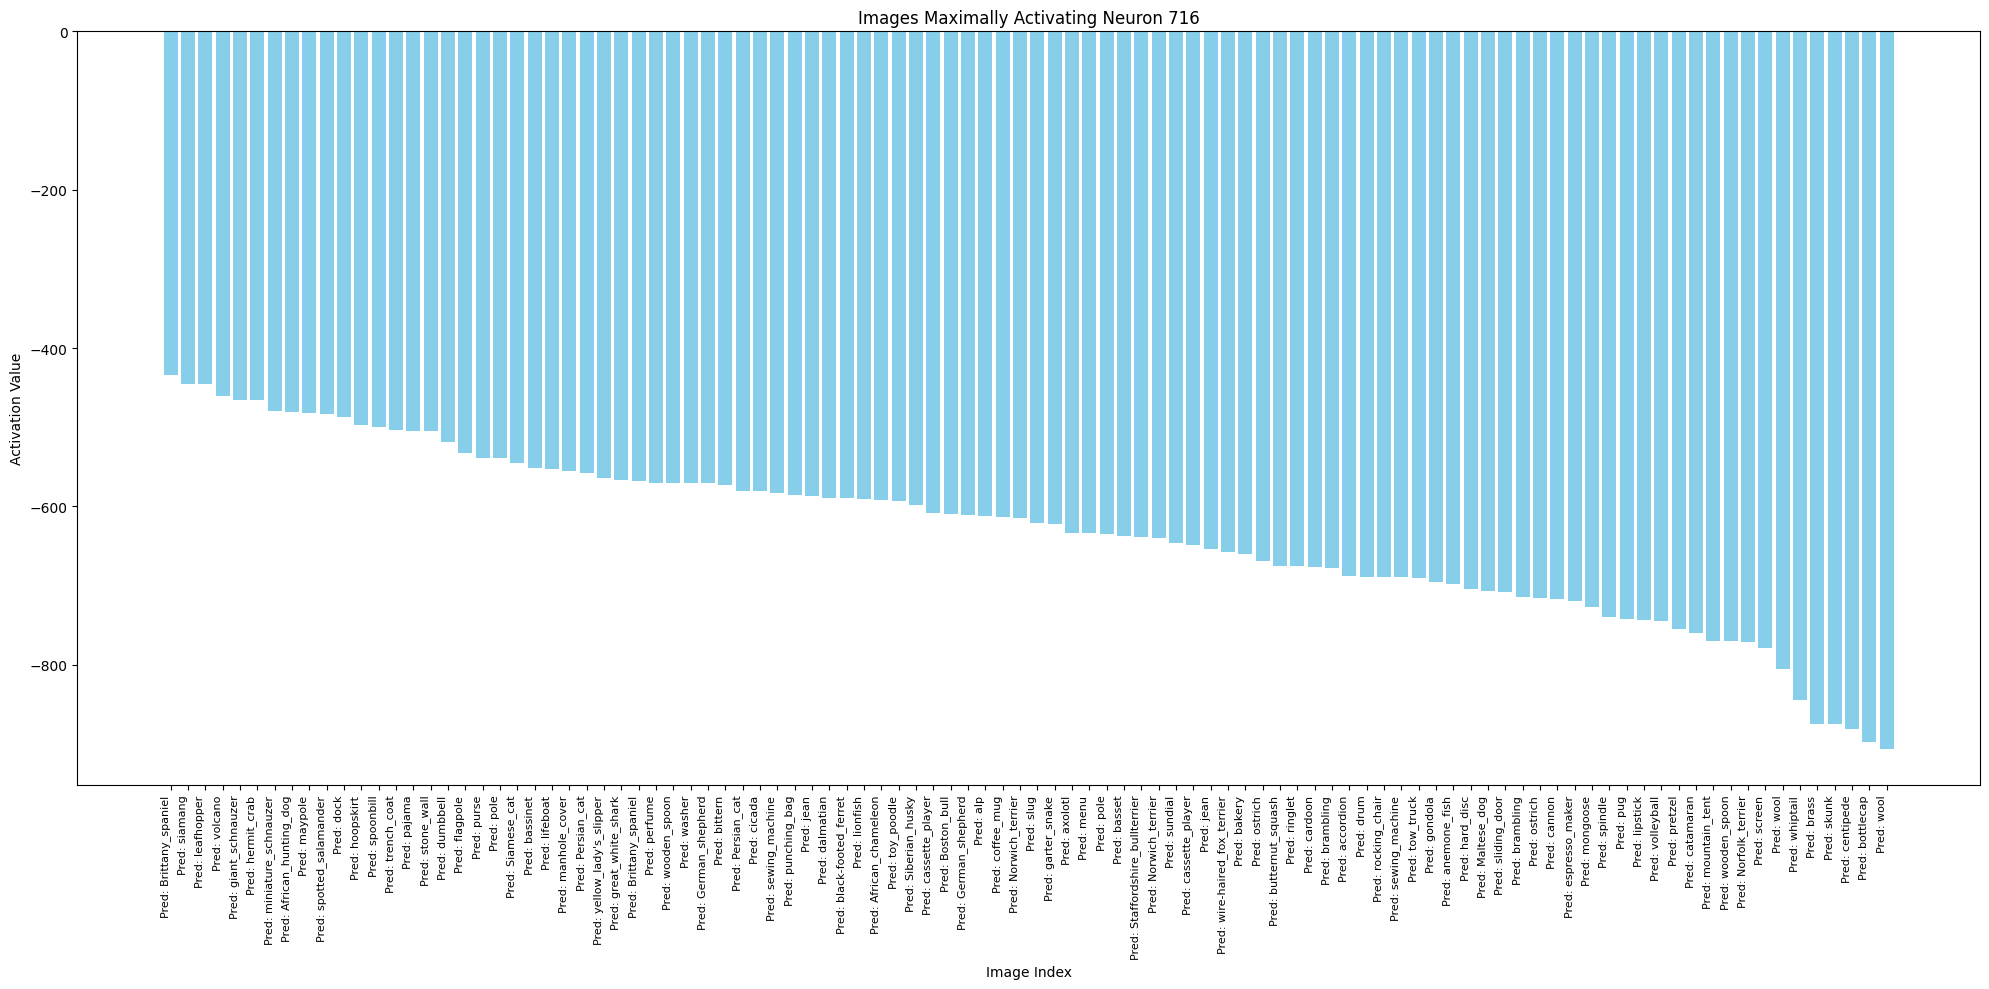

In [ ]:
# Plotting the bar graph
plt.figure(figsize=(20, 10))

plt.bar(sorted_activations['image_idx'].astype(str), sorted_activations['activation_value'], color='skyblue')

# Adding the labels
plt.xticks(sorted_activations['image_idx'].astype(str), labels, rotation=90, size=8, ha='right')

plt.xlabel('Image Index')
plt.ylabel('Activation Value')
plt.title(f'Images Maximally Activating Neuron {specific_neuron_idx}')
plt.tight_layout()
plt.show()

In [ ]:
# Go through every neuron, print top 5 most activating images

# Assuming 'grouped_activations' is the DataFrame from the previous steps

# Get unique neurons
unique_neurons = grouped_activations['neuron_idx'].unique()

# Loop through each neuron
for neuron_idx in unique_neurons:
    # Filter for the current neuron
    filtered_activations = grouped_activations[grouped_activations['neuron_idx'] == neuron_idx]

    # Sort by activation value
    sorted_activations = filtered_activations.sort_values(by='activation_value', ascending=False)

    # Get the top 5 images
    top_images = sorted_activations.head(10)
    bottom_images  = sorted_activations.tail(10)


    # Print the results
    print(f"Neuron {neuron_idx} - Top 5 Activating Images:")
    for idx, row in top_images.iterrows():
        print(f"  Image Index: {row['image_idx']}, Activation Value: {row['activation_value']}, True Class: {row['class_name']}, Predicted Class: {row['predicted']}")
    print("\n")

      # Print the results
    print(f"Neuron {neuron_idx} - Top 5 Least Activating Images:")
    for idx, row in bottom_images.iterrows():
        print(f"  Image Index: {row['image_idx']}, Activation Value: {row['activation_value']}, True Class: {row['class_name']}, Predicted Class: {row['predicted']}")
    print("\n")


Neuron 0 - Top 5 Activating Images:
  Image Index: 40, Activation Value: -35.80337514728308, True Class: wallaby, Predicted Class: mongoose
  Image Index: 63, Activation Value: -70.593606043607, True Class: little_blue_heron, Predicted Class: spoonbill
  Image Index: 92, Activation Value: -99.05100257694721, True Class: parallel_bars, Predicted Class: rocking_chair
  Image Index: 69, Activation Value: -121.57792362570763, True Class: pier, Predicted Class: dock
  Image Index: 88, Activation Value: -130.2174333035946, True Class: coffee_mug, Predicted Class: jean
  Image Index: 24, Activation Value: -141.76623190939426, True Class: sewing_machine, Predicted Class: sewing_machine
  Image Index: 45, Activation Value: -142.38706969469786, True Class: nail, Predicted Class: yellow_lady's_slipper
  Image Index: 49, Activation Value: -148.94185646995902, True Class: crane, Predicted Class: ostrich
  Image Index: 74, Activation Value: -149.1943969540298, True Class: manhole_cover, Predicted Cl

Neuron 139 - Top 5 Activating Images:
  Image Index: 62, Activation Value: 128.16992244124413, True Class: lifeboat, Predicted Class: lifeboat
  Image Index: 53, Activation Value: -137.50027959048748, True Class: tiger_shark, Predicted Class: great_white_shark
  Image Index: 72, Activation Value: -149.73544198274612, True Class: trimaran, Predicted Class: catamaran
  Image Index: 63, Activation Value: -285.8308165073395, True Class: little_blue_heron, Predicted Class: spoonbill
  Image Index: 99, Activation Value: -297.7447347044945, True Class: book_jacket, Predicted Class: hard_disc
  Image Index: 69, Activation Value: -322.1364820301533, True Class: pier, Predicted Class: dock
  Image Index: 10, Activation Value: -334.63400822877884, True Class: Boston_bull, Predicted Class: Staffordshire_bullterrier
  Image Index: 27, Activation Value: -340.5224898159504, True Class: hamper, Predicted Class: accordion
  Image Index: 16, Activation Value: -341.911524951458, True Class: ballpoint, Pr

# Localization Neurons?

Do some neurons consistently respond to specific patches?

My intuitive guess is no, as attention likely deals with these computations, but let's find out empirically. I would also not expect local MLP layers to be in the last layer, and more likely early layers.